In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import folium
import openpyxl
import seaborn as sns
import re
import datetime as dt
from datetime import timedelta
%matplotlib inline

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [2]:
#read in the data

members = pd.read_csv('data/NSS_GreatCare_Members.csv')
hosp_admish = pd.read_csv('data/NSS_Hospital_Inpatient_Admissions.csv')
pc_visits = pd.read_csv('data/NSS_PrimaryCare_Office_Visits.csv', low_memory=False)

In [100]:
pc_visits.head()
pc_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231373 entries, 0 to 231372
Data columns (total 18 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   Encounter ID                                   231373 non-null  object 
 1   Patient ID                                     231373 non-null  object 
 2   Service Provider ID                            230599 non-null  object 
 3   Attending Provider ID                          39644 non-null   object 
 4   Provider Group Provider ID                     227644 non-null  object 
 5   Facility Provider ID                           39756 non-null   object 
 6   Encounter Primary Payor ID                     231373 non-null  object 
 7   Encounter Primary Plan ID                      231373 non-null  object 
 8   Attending Provider NPI                         39644 non-null   float64
 9   Facility Provider NPI                

In [4]:
hosp_admish.head()
#hosp_admish.info()

,Encounter ID,Patient ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Facility Provider ID,Attending Provider ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Is Emergency Department Visit Parent Encounter,Is Observation Stay Parent Encounter,CMS Admit Type Code,CMS Admit Source Code,CMS Patient Discharge Status Code,CMS Place of Service Code,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Primary Plan Allowed Amount,Primary Plan Paid Amount,Patient Paid Amount
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,DS1|1,DS1|5047W,DS1|NPI|1306890389,DS1|NPI|1417170523,1.417171e+09,1306890389,2013-01-12,2013-01-14,0,0,1.0,1,1,21.0,NaN,NaN,O70.0,First degree perineal laceration during delivery,0,6620.72,250.0
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,DS1|1,DS1|5047Y,DS1|NPI|1902803315,DS1|NPI|1669599197,1.669599e+09,1902803315,2014-01-05,2014-01-12,0,0,3.0,1,1,21.0,348.4,Compression of brain,NaN,NaN,0,46465.40,250.0
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,DS1|1,DS1|5047X,DS1|NPI|1902803315,DS1|NPI|1407880511,1.407881e+09,1902803315,2012-06-13,2012-06-21,1,0,1.0,1,1,21.0,NaN,NaN,K91.71,Accidental puncture and laceration of a digest...,0,43879.13,250.0
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1407008907,1.407009e+09,1427055839,2012-12-06,2012-12-09,0,0,3.0,1,1,21.0,NaN,NaN,O70.1,Second degree perineal laceration during delivery,0,14800.00,250.0
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,DS1|1,DS1|5047W,DS1|NPI|1992818256,DS1|NPI|1518045608,1.518046e+09,1992818256,2015-03-11,2015-03-14,0,0,2.0,2,1,NaN,NaN,NaN,F32.9,"Major depressive disorder, single episode, uns...",0,0.00,0.0


In [5]:
members
#members.info()

,Patient ID,Primary Plan ID,Primary Payor ID,Is Patient Alive,Patient Age Integer,Patient Date of Birth,Patient ZIP Code 5-Digit,Count Primary Care Visits in Last 36 Months,Count Visits with Attributee Individual Primary Care Provider i,Count Visits with Attributee Primary Care Provider Group in Las,Administratively Assigned PCP Provider NPI,Empirically Attributed PCP Individual Provider NPI,Empirically Attributed PCP Individual Provider Description,Empirically Attributed PCP Group Provider NPI,Empirically Attributed PCP Group Provider Description,Primary Plan Description,Primary Payor Description,Primary Plan Financial Class Description,Is Primary Plan Financial Class Commercial,Is Primary Plan Financial Class Medicare FFS,Is Primary Plan Financial Class Medicare Advantage,Is Primary Plan Financial Class Medicaid,Is Primary Plan Financial Class Other,Count Active Plan Memberships,Is Medicaid Eligible,CMS Dual Status Code,Is CMS ESRD Status,Is CMS Hospice Status,Count CCW Conditions,Is CCW Acquired Hypothyroidism,Is CCW Acute Myocardial Infarction,Is CCW Alzheimers Disease,Is CCW Alzheimers Disease and Related Disorders or Senile Deme,Is CCW Anemia,Is CCW Asthma,Is CCW Atrial Fibrillation,Is CCW Benign Prostatic Hyperplasia,Is CCW Breast Cancer,Is CCW Cataract,Is CCW CKD,Is CCW COPD and Bronchiectasis,Is CCW Colorectal Cancer,Is CCW Depression,Is CCW Diabetes,Is CCW Endometrial Cancer,Is CCW Glaucoma,Is CCW Heart Failure,Is CCW Hip or Pelvic Fracture,Is CCW Hyperlipidemia,Is CCW Hypertension,Is CCW Ischemic Heart Disease,Is CCW Lung Cancer,Is CCW Osteoporosis,Is CCW Prostate Cancer,Is CCW Rheumatoid Arthritis or Osteoarthritis,Is CCW Stroke or Transient Ischemic Attack,Is CCW ASCVD,Is CCW Anxiety Disorders,Is CCW Depressive Disorders,Is CCW Schizophrenia or Other Psychotic Disorders,Is CCW Bipolar Disorder,Period Start Date,Period End Date
0,DS1|1,DS1|5047W,DS1|1,1,54,1958-11-08,92111.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GreatCare Gold,NaN,Commercial,1,0,0,0,0,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013-01-01 00:00:00+00,2013-04-11 00:00:00+00
1,DS1|10,DS1|5047W,DS1|1,1,54,1958-12-10,90024.0,6,1.0,5.0,NaN,1.457336e+09,"NELSEN, KAY M.",1.144213e+09,REGENTS OF THE UNIV OF CA,GreatCare Gold,NaN,Commercial,1,0,0,0,0,1,0,NaN,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2012-12-10 00:00:00+00,2013-01-01 00:00:00+00
2,DS1|100,DS1|5047W,DS1|1,1,2,2012-08-04,90008.0,1,1.0,1.0,NaN,1.477565e+09,"KAMINKER, SHARON .",1.043427e+09,UCLA MEDICAL GROUP,GreatCare Gold,NaN,Commercial,1,0,0,0,0,1,0,NaN,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2015-04-18 00:00:00+00,2015-05-18 00:00:00+00
3,DS1|1000,DS1|5047W,DS1|1,1,6,2003-12-25,94131.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GreatCare Gold,NaN,Commercial,1,0,0,0,0,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010-01-01 00:00:00+00,2010-04-09 00:00:00+00
4,DS1|10000,DS1|5047W,DS1|1,1,7,2005-07-15,90301.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GreatCare Gold,NaN,Commercial,1,0,0,0,0,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012-08-01 00:00:00+00,2012-10-02 00:00:00+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61514,DS1|9995,DS1|5047W,DS1|1,1,47,1963-07-26,92104.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GreatCare Gold,NaN,Commercial,1,0,0,0,0,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011-01-01 00:00:00+00,2011-01-15 00:00:00+00
61515,DS1|9996,DS1|5047X,DS1|1,1,26,1983-04-17,94122.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GreatCare Silver,NaN,Commercial,1,0,0,0,0,1,0,NaN,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010-03-28 00:00:00+00,2010-04-17 00:00:00+00
61516,DS1|9997,DS1|5047W,DS1|1,1,4,2008-12-11,92840.

### 1. What is our 30-day all cause readmission rate across hospitals our members are admitted to?

In [6]:
#look at start and end date of all hospital visits. drop irrelevant columns, count admissions for denominator (6,213)
hosp_stay = hosp_admish[['Patient ID','Encounter Start Date','Encounter End Date',
                         'Attending Provider NPI','Facility Provider NPI']]

#convert dates from objects to datetimes, convert floats to objects
hosp_stay.loc[:,['Encounter Start Date','Encounter End Date']] = hosp_stay.loc[:,['Encounter Start Date','Encounter End Date']].apply(pd.to_datetime)
hosp_stay = hosp_stay.astype({'Attending Provider NPI':object})

# hosp_stay.head()
hosp_stay.info()
#hosp_stay.count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6213 entries, 0 to 6212
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Patient ID              6213 non-null   object        
 1   Encounter Start Date    6213 non-null   datetime64[ns]
 2   Encounter End Date      6213 non-null   datetime64[ns]
 3   Attending Provider NPI  5884 non-null   object        
 4   Facility Provider NPI   6213 non-null   object        
dtypes: datetime64[ns](2), object(3)
memory usage: 242.8+ KB


C:\Users\rgher\anaconda\lib\site-packages\pandas\core\indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [7]:
#if using the unique patients admitted as denominator, drop duplicate patients and count rows (4,701 unique patients)
# num_patients = hosp_stay.drop_duplicates('Patient ID')
# num_patients.count()

In [8]:
#group by patient ID and filter out any patients under 2 visits

readmish = hosp_stay.groupby('Patient ID')['Encounter Start Date'].count().reset_index()
readmish = readmish[readmish['Encounter Start Date'] >= 2]
readmish.rename({'Encounter Start Date':'# of admissions'}, axis=1)

,Patient ID,# of admissions
8,DS1|10132,2
17,DS1|10253,3
18,DS1|10291,2
32,DS1|10451,12
37,DS1|10507,2
...,...,...
4679,DS1|9809,2
4683,DS1|9864,2
4690,DS1|9935,3
4692,DS1|9943,3


In [9]:
#filter hospital stay to patients with more than one stay (from readmish table). DEBBIE'S GENIUS CODE TO CREATE NEW COLUMN
#THAT TAKES PATIENT'S NEXT START DATE AND ADDS IT TO SAME LINE AS PREVIOUS VISIT
multistay = hosp_stay[hosp_stay['Patient ID'].isin(readmish['Patient ID'])]
multistay['Next Start Date'] = multistay.sort_values('Encounter Start Date',ascending=True).groupby('Patient ID')['Encounter Start Date'].shift(-1)
multistay

<ipython-input-9-95faf4484be2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multistay['Next Start Date'] = multistay.sort_values('Encounter Start Date',ascending=True).groupby('Patient ID')['Encounter Start Date'].shift(-1)


,Patient ID,Encounter Start Date,Encounter End Date,Attending Provider NPI,Facility Provider NPI,Next Start Date
7,DS1|10132,2013-08-14,2013-08-16,NaN,1366545311,NaT
8,DS1|10132,2013-03-30,2013-04-01,1417995317.0,1386741635,2013-08-14
17,DS1|10253,2011-10-15,2011-11-13,1750346474.0,1215987532,NaT
18,DS1|10253,2010-06-02,2010-06-06,1932127248.0,1396725677,2011-10-15
19,DS1|10253,2010-04-02,2010-04-16,1346566221.0,1689772592,2010-06-02
...,...,...,...,...,...,...
6201,DS1|9943,2013-10-01,2013-10-16,1932297231.0,1184722779,2013-10-25
6202,DS1|9943,2013-10-25,2013-10-28,1942320288.0,1184722779,2014-10-28
6203,DS1|9943,2014-10-28,2014-10-30,1265649966.0,1184722779,NaT
6210,DS1|9994,2015-11-21,2015-11-23,1861831836.0,1689608150,2015-11-24


In [10]:
#subtract next start date from last end date and create new column for these results
multistay['Days Between'] = multistay['Next Start Date'] - multistay['Encounter End Date']
multistay

<ipython-input-10-2e82419d3d6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multistay['Days Between'] = multistay['Next Start Date'] - multistay['Encounter End Date']


,Patient ID,Encounter Start Date,Encounter End Date,Attending Provider NPI,Facility Provider NPI,Next Start Date,Days Between
7,DS1|10132,2013-08-14,2013-08-16,NaN,1366545311,NaT,NaT
8,DS1|10132,2013-03-30,2013-04-01,1417995317.0,1386741635,2013-08-14,135 days
17,DS1|10253,2011-10-15,2011-11-13,1750346474.0,1215987532,NaT,NaT
18,DS1|10253,2010-06-02,2010-06-06,1932127248.0,1396725677,2011-10-15,496 days
19,DS1|10253,2010-04-02,2010-04-16,1346566221.0,1689772592,2010-06-02,47 days
...,...,...,...,...,...,...,...
6201,DS1|9943,2013-10-01,2013-10-16,1932297231.0,1184722779,2013-10-25,9 days
6202,DS1|9943,2013-10-25,2013-10-28,1942320288.0,1184722779,2014-10-28,365 days
6203,DS1|9943,2014-10-28,2014-10-30,1265649966.0,1184722779,NaT,NaT
6210,DS1|9994,2015-11-21,2015-11-23,1861831836.0,1689608150,2015-11-24,1 days


In [11]:
#create another column to define whether 'Days Between' is less than 30 or not. Used Teng's for loop

t = []

for i in multistay['Days Between']:
    if (i <= dt.timedelta(days=30)) and (i >= dt.timedelta(days=0)) :
        t.append('yes')
    else:
        t.append('no')

multistay['Under 30 Days'] = t
multistay

<ipython-input-11-7a47abd84312>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multistay['Under 30 Days'] = t


,Patient ID,Encounter Start Date,Encounter End Date,Attending Provider NPI,Facility Provider NPI,Next Start Date,Days Between,Under 30 Days
7,DS1|10132,2013-08-14,2013-08-16,NaN,1366545311,NaT,NaT,no
8,DS1|10132,2013-03-30,2013-04-01,1417995317.0,1386741635,2013-08-14,135 days,no
17,DS1|10253,2011-10-15,2011-11-13,1750346474.0,1215987532,NaT,NaT,no
18,DS1|10253,2010-06-02,2010-06-06,1932127248.0,1396725677,2011-10-15,496 days,no
19,DS1|10253,2010-04-02,2010-04-16,1346566221.0,1689772592,2010-06-02,47 days,no
...,...,...,...,...,...,...,...,...
6201,DS1|9943,2013-10-01,2013-10-16,1932297231.0,1184722779,2013-10-25,9 days,yes
6202,DS1|9943,2013-10-25,2013-10-28,1942320288.0,1184722779,2014-10-28,365 days,no
6203,DS1|9943,2014-10-28,2014-10-30,1265649966.0,1184722779,NaT,NaT,no
6210,DS1|9994,2015-11-21,2015-11-23,1861831836.0,1689608150,2015-11-24,1 days,yes


In [12]:
#Why doesn't this work?
# thirty_dict = {dt.timedelta(days<=30):'yes',dt.timedelta(days>30):'no'}

# multistay['Under 30 Days'] = multistay['Days Between'].map(thirty_dict)
# multistay

In [13]:
#count yes, use as numerator to calculate rate of <30 Day Readmission
yes = len(multistay[multistay['Under 30 Days']=='yes']) 
#yes

total_admish = len(hosp_stay)
total_admish

6213

In [14]:
#calculate the rate
rate_under_30days = round((yes/total_admish)*100,2)
rate_under_30days

11.2

In [15]:
#for potential other exploration, identify the members who have had under 30-day readmissions
in_readmission = multistay[multistay['Under 30 Days']=='yes']
in_readmission.head()

,Patient ID,Encounter Start Date,Encounter End Date,Attending Provider NPI,Facility Provider NPI,Next Start Date,Days Between,Under 30 Days
34,DS1|10451,2014-04-24,2014-04-26,1306902739.0,1023010113,2014-05-23,27 days,yes
35,DS1|10451,2013-03-20,2013-03-23,1518963032.0,1063412005,2013-03-27,4 days,yes
37,DS1|10451,2013-04-16,2013-04-26,1427344951.0,1427055839,2013-05-01,5 days,yes
39,DS1|10451,2013-06-25,2013-07-01,1073566931.0,1427055839,2013-07-26,25 days,yes
40,DS1|10451,2013-07-26,2013-08-03,1679541775.0,1427055839,2013-08-31,28 days,yes


In [16]:
#How many of these are 0 days? Enough to make a difference?
zero_days = in_readmission[in_readmission['Days Between'] == dt.timedelta(days=0)]
len(zero_days)

122

In [17]:
#IS THIS A LOT?
rate_zero_days = round((len(zero_days)/len(in_readmission))*100,2)
rate_zero_days

17.53

In [18]:
zero_days

zero_by_hosp = zero_days.groupby('Facility Provider NPI')['Patient ID'].count().reset_index().sort_values('Patient ID',ascending=False)
zero_by_hosp = zero_by_hosp.rename({'Patient ID':'Count of Readmissions','Facility Provider NPI':'Hospital'},axis=1)
zero_by_hosp['Percentage'] = round((zero_by_hosp['Count of Readmissions']/zero_by_hosp['Count of Readmissions'].sum())*100,2)
zero_by_hosp.head(10)

,Hospital,Count of Readmissions,Percentage
55,1902803315,17,13.93
44,1710918545,12,9.84
24,1427055839,9,7.38
12,1184722779,7,5.74
0,0000000000,4,3.28
38,1689772592,4,3.28
3,1033298617,3,2.46
22,1407839921,3,2.46
52,1841277704,3,2.46
51,1811080526,2,1.64


### 1a. Rate per Month

In [19]:
#oldest and newest end dates for reference
hosp_stay_rec = hosp_stay[hosp_stay['Encounter End Date'] == hosp_stay['Encounter End Date'].max()]
hosp_stay_rec

,Patient ID,Encounter Start Date,Encounter End Date,Attending Provider NPI,Facility Provider NPI
3470,DS1|40578,2019-04-28,2019-05-01,1295062321.0,1033298617


In [20]:
hosp_stay_old = hosp_stay[hosp_stay['Encounter End Date'] == hosp_stay['Encounter End Date'].min()]
hosp_stay_old

,Patient ID,Encounter Start Date,Encounter End Date,Attending Provider NPI,Facility Provider NPI
77,DS1|10734,2009-11-11,2009-11-25,1629382395.0,1104982917


In [21]:
#group hosp_stay by month to see admissions by month. First add a column that lists month & year
hosp_stay['Month/Year'] = hosp_stay['Encounter End Date'].dt.to_period('M')
hosp_stay

,Patient ID,Encounter Start Date,Encounter End Date,Attending Provider NPI,Facility Provider NPI,Month/Year
0,DS1|10033,2013-01-12,2013-01-14,1417170523.0,1306890389,2013-01
1,DS1|10043,2014-01-05,2014-01-12,1669599197.0,1902803315,2014-01
2,DS1|10073,2012-06-13,2012-06-21,1407880511.0,1902803315,2012-06
3,DS1|10101,2012-12-06,2012-12-09,1407008907.0,1427055839,2012-12
4,DS1|10118,2015-03-11,2015-03-14,1518045608.0,1992818256,2015-03
...,...,...,...,...,...,...
6208,DS1|9979,2015-02-06,2015-02-11,1720043417.0,1689772592,2015-02
6209,DS1|9981,2014-08-07,2014-08-10,1215968474.0,1427055839,2014-08
6210,DS1|9994,2015-11-21,2015-11-23,1861831836.0,1689608150,2015-11
6211,DS1|9994,2015-11-24,2015-11-27,1750544516.0,1689608150,2015-11


In [22]:
#group admissions into month buckets
monthly_stay_count = hosp_stay.groupby('Month/Year')['Patient ID'].count().reset_index()
monthly_stay_count = monthly_stay_count.rename({'Patient ID':'Admission Count'}, axis=1)
monthly_stay_count

,Month/Year,Admission Count
0,2009-11,2
1,2009-12,26
2,2010-01,45
3,2010-02,30
4,2010-03,31
...,...,...
109,2018-12,1
110,2019-01,1
111,2019-02,4
112,2019-04,1


In [23]:
#same steps as above to calculate readmissions under 30 days on monthly basis. SHOULD THIS BE BASED ON END DATE OR NEXT ADMISH??
in_readmission['Month/Year'] = in_readmission['Encounter End Date'].dt.to_period('M')
in_readmission

<ipython-input-23-05e16de6738d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_readmission['Month/Year'] = in_readmission['Encounter End Date'].dt.to_period('M')


,Patient ID,Encounter Start Date,Encounter End Date,Attending Provider NPI,Facility Provider NPI,Next Start Date,Days Between,Under 30 Days,Month/Year
34,DS1|10451,2014-04-24,2014-04-26,1306902739.0,1023010113,2014-05-23,27 days,yes,2014-04
35,DS1|10451,2013-03-20,2013-03-23,1518963032.0,1063412005,2013-03-27,4 days,yes,2013-03
37,DS1|10451,2013-04-16,2013-04-26,1427344951.0,1427055839,2013-05-01,5 days,yes,2013-04
39,DS1|10451,2013-06-25,2013-07-01,1073566931.0,1427055839,2013-07-26,25 days,yes,2013-07
40,DS1|10451,2013-07-26,2013-08-03,1679541775.0,1427055839,2013-08-31,28 days,yes,2013-08
...,...,...,...,...,...,...,...,...,...
6184,DS1|9809,2013-01-09,2013-01-11,1982836466.0,1689608150,2013-01-20,9 days,yes,2013-01
6198,DS1|9935,2011-01-22,2011-01-24,1376864215.0,1669456299,2011-01-25,1 days,yes,2011-01
6199,DS1|9935,2011-01-25,2011-01-26,1972545085.0,1902803315,2011-01-26,0 days,yes,2011-01
6201,DS1|9943,2013-10-01,2013-10-16,1932297231.0,1184722779,2013-10-25,9 days,yes,2013-10


In [24]:
zero_days


,Patient ID,Encounter Start Date,Encounter End Date,Attending Provider NPI,Facility Provider NPI,Next Start Date,Days Between,Under 30 Days
45,DS1|10451,2013-03-27,2013-04-16,1811123151.0,1902844988,2013-04-16,0 days,yes
66,DS1|10698,2012-01-03,2012-01-04,1295777282.0,1902803315,2012-01-04,0 days,yes
80,DS1|10734,2010-12-29,2011-01-04,1932307808.0,1427055839,2011-01-04,0 days,yes
96,DS1|10830,2011-06-14,2011-06-15,NaN,1538265780,2011-06-15,0 days,yes
216,DS1|11785,2013-12-23,2013-12-28,1639155930.0,1134564693,2013-12-28,0 days,yes
...,...,...,...,...,...,...,...,...
5799,DS1|6142,2012-03-22,2012-03-24,1679869762.0,1013062769,2012-03-24,0 days,yes
5981,DS1|7733,2013-03-24,2013-03-29,1487765913.0,1043502750,2013-03-29,0 days,yes
6132,DS1|9391,2015-02-12,2015-02-17,1417085978.0,1841277704,2015-02-17,0 days,yes
6178,DS1|9770,2014-03-20,2014-03-22,1972758787.0,1750491247,2014-03-22,0 days,yes


In [25]:
#group readmissions into month buckets
monthly_read_count = in_readmission.groupby('Month/Year')['Patient ID'].count().reset_index()
monthly_read_count = monthly_read_count.rename({'Patient ID':'Readmission Count'}, axis=1)
monthly_read_count

,Month/Year,Readmission Count
0,2009-12,6
1,2010-01,3
2,2010-03,3
3,2010-04,10
4,2010-05,4
...,...,...
90,2017-09,3
91,2018-01,1
92,2018-03,1
93,2018-04,1


In [26]:
#combine admission and readmission counts per month in new df and create new column for monthly rate
rate_per_month = monthly_stay_count.merge(monthly_read_count, on='Month/Year', how='left')
rate_per_month['Admission Count'] = rate_per_month['Admission Count'].astype(float)
#THOUGHT I NEEDED THIS FOR CHART, BUT DOESNT WORK: rate_per_month['Month/Year'] = rate_per_month['Month/Year'].astype(float)
rate_per_month['Under 30 Rate'] = round((rate_per_month['Readmission Count']/rate_per_month['Admission Count'])*100,2)
rate_per_month

,Month/Year,Admission Count,Readmission Count,Under 30 Rate
0,2009-11,2.0,NaN,NaN
1,2009-12,26.0,6.0,23.08
2,2010-01,45.0,3.0,6.67
3,2010-02,30.0,NaN,NaN
4,2010-03,31.0,3.0,9.68
...,...,...,...,...
109,2018-12,1.0,NaN,NaN
110,2019-01,1.0,NaN,NaN
111,2019-02,4.0,NaN,NaN
112,2019-04,1.0,NaN,NaN


In [27]:
#calculate mean
round(rate_per_month['Under 30 Rate'].mean(),2)

12.59

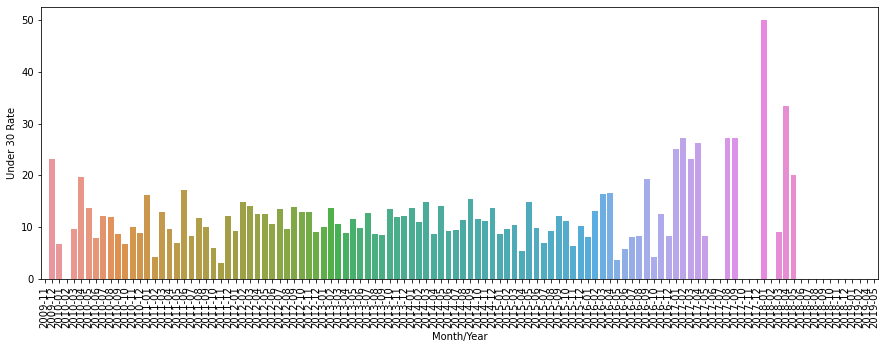

In [28]:
#WHY DOESN'T LINE PLOT WORK?

fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(data=rate_per_month, x='Month/Year', y='Under 30 Rate')
plt.xticks(rotation=90);

### 1b. By Condition?

In [31]:
# conditions = members.merge(in_readmission,on='Patient ID', how='left')
# conditions
# conditions = conditions[['Is CCW Acquired Hypothyroidism','Is CCW Acute Myocardial Infarction','Is CCW Alzheimers Disease',
# 'Is CCW Alzheimers Disease and Related Disorders or Senile Deme','Is CCW Anemia','Is CCW Asthma','Is CCW Atrial Fibrillation',
# 'Is CCW Benign Prostatic Hyperplasia','Is CCW Breast Cancer','Is CCW Cataract','Is CCW CKD','Is CCW COPD and Bronchiectasis',
# 'Is CCW Colorectal Cancer','Is CCW Depression','Is CCW Diabetes','Is CCW Endometrial Cancer','Is CCW Glaucoma',
# 'Is CCW Heart Failure','Is CCW Hip or Pelvic Fracture','Is CCW Hyperlipidemia','Is CCW Hypertension',
# 'Is CCW Ischemic Heart Disease','Is CCW Lung Cancer','Is CCW Osteoporosis','Is CCW Prostate Cancer','Is CCW Rheumatoid Arthritis or Osteoarthritis',
# 'Is CCW Stroke or Transient Ischemic Attack','Is CCW ASCVD','Is CCW Anxiety Disorders','Is CCW Depressive Disorders',
# 'Is CCW Schizophrenia or Other Psychotic Disorders','Is CCW Bipolar Disorder']]

In [32]:
discharge = hosp_admish[['Principal Discharge Diagnosis ICD-9-CM Description', 'Patient ID', 'Encounter End Date']]
discharge['Encounter End Date'] = pd.to_datetime(discharge['Encounter End Date'])
conditions = discharge.merge(in_readmission, on=['Patient ID', 'Encounter End Date'])
conditions = conditions.groupby(['Patient ID','Principal Discharge Diagnosis ICD-9-CM Description']).count()
conditions
#discharge.info()

<ipython-input-32-2f0314a927b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discharge['Encounter End Date'] = pd.to_datetime(discharge['Encounter End Date'])


Encounter End Date  \
Patient ID Principal Discharge Diagnosis ICD-9-CM Description                       
DS1|10451  Acute alcoholic hepatitis                                            1   
           Alcoholic cirrhosis of liver                                         3   
           Toxic effect of ethyl alcohol                                        1   
DS1|10734  Paroxysmal ventricular tachycardia                                   1   
DS1|11433  Diabetes with ketoacidosis, type II or unspecif...                   1   
...                                                                           ...   
DS1|9217   Hepatic encephalopathy                                               1   
DS1|9511   Infantile spasms, without mention of intractabl...                   1   
           Localization-related (focal) (partial) epilepsy...                   1   
DS1|9710   Other current conditions classifiable elsewhere...                   1   
DS1|9770   Subendocardial infarction, initial episode of care                   1   

                                                               Encounter Start Date  \
Patient ID Principal Discharge Diagnosis ICD-9-CM Description                         
DS1|10451  Acute alcoholic hepatitis                                              1   
           Alcoholic cirrhosis of liver                                           3   
           Toxic effect of ethyl alcohol                                          1   
DS1|10734  Paroxysmal ventricular tachycardia                                     1   
DS1|11433  Diabetes with ketoacidosis, type II or unspecif...                     1   
...                                                                             ...   
DS1|9217   Hepatic encephalopathy                                                 1   
DS1|9511   Infantile spasms, without mention of intractabl...                     1   
           Localization-related (focal) (partial) epilepsy...                     1   
DS1|9710   Other current conditions classifiable elsewhere...                     1   
DS1|9770   Subendocardial infarction, initial episode of care                     1   

                                                               Attending Provider NPI  \
Patient ID Principal Discharge Diagnosis ICD-9-CM Description                           
DS1|10451  Acute alcoholic hepatitis                                                1   
           Alcoholic cirrhosis of liver                                             3   
           Toxic effect of ethyl alcohol                                            1   
DS1|10734  Paroxysmal ventricular tachycardia                                       1   
DS1|11433  Diabetes with ketoacidosis, type II or unspecif...                       1   
...                                                                               ...   
DS1|9217   Hepatic encephalopathy                                                   1   
DS1|9511   Infantile spasms, without mention of intractabl...                       1   
           Localization-related (focal) (partial) epilepsy...                       1   
DS1|9710   Other current conditions classifiable elsewhere...                       1   
DS1|9770   Subendocardial infarction, initial episode of care                       1   

                                                               Facility Provider NPI  \
Patient ID Principal Discharge Diagnosis ICD-9-CM Description                          
DS1|10451  Acute alcoholic hepatitis                                               1   
           Alcoholic cirrhosis of liver                                            3   
           Toxic effect of ethyl alcohol                                           1   
DS1|10734  Paroxysmal ventricular tachycardia                                      1   
DS1|11433  Diabetes with ketoacidosis, type II or unspecif...                      1   
...                                                

### 2. What percent of patients have a PCP visit within a week of discharge?

In [33]:
pc_visits.head()

,Encounter ID,Patient ID,Service Provider ID,Attending Provider ID,Provider Group Provider ID,Facility Provider ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Attending Provider NPI,Facility Provider NPI,Service Provider NPI,Provider Group NPI,Encounter Date,Is Qualifying Preventive Primary Care Service,Is Qualifying Primary Care Service Provider,Is Qualifying Primary Care Attending,Is Qualifying Primary Care Provider Group,Qualifying Preventive Primary Care HCPCS Code
0,COV|EE|DS1|10076|20110225|DS1|NPI|1487856779,DS1|10076,DS1|NPI|1487856779,NaN,DS1|NPI|1043427248,NaN,DS1|1,DS1|5047W,NaN,NaN,1.487857e+09,1.043427e+09,2011-02-18,0,1,0,0,NaN
1,COV|EE|DS1|10088|20140222|DS1|NPI|1528030996,DS1|10088,DS1|NPI|1528030996,DS1|NPI|1528030996,DS1|NPI|1043427248,DS1|NPI|1902803315,DS1|1,DS1|5047W,1.528031e+09,1.902803e+09,1.528031e+09,1.043427e+09,2014-02-22,0,1,1,1,NaN
2,COV|EE|DS1|10165|20140907|DS1|NPI|1477579365,DS1|10165,DS1|NPI|1477579365,NaN,DS1|NPI|1043427248,NaN,DS1|1,DS1|5047W,NaN,NaN,1.477579e+09,1.043427e+09,2014-08-31,0,1,0,0,NaN
3,COV|EE|DS1|10240|20130624|DS1|NPI|1821178088,DS1|10240,DS1|NPI|1821178088,DS1|NPI|1821178088,DS1|NPI|1407058787,DS1|NPI|1104842020,DS1|1,DS1|5047W,1.821178e+09,1.104842e+09,1.821178e+09,1.407059e+09,2013-06-17,0,1,1,1,NaN
4,COV|EE|DS1|10293|20160904|DS1|NPI|1609004191,DS1|10293,DS1|NPI|1609004191,NaN,DS1|NPI|1184722779,NaN,DS1|1,DS1|5047X,NaN,NaN,1.609004e+09,1.184723e+09,2016-09-04,0,1,0,0,NaN


In [34]:
#limit columns, convert relevant ones to objects and Encounter Date to datetime
pcp_trips = pc_visits[['Patient ID', 'Attending Provider NPI', 'Facility Provider NPI', 'Provider Group NPI', 'Encounter Date']]
pcp_trips = pcp_trips.astype(object)
pcp_trips['Encounter Date'] = pd.to_datetime(pcp_trips['Encounter Date'])
pcp_trips = pcp_trips.rename({'Encounter Date':'PCP Date'}, axis=1)
pcp_trips.head()


,Patient ID,Attending Provider NPI,Facility Provider NPI,Provider Group NPI,PCP Date
0,DS1|10076,NaN,NaN,1043427248.0,2011-02-18
1,DS1|10088,1528030996.0,1902803315.0,1043427248.0,2014-02-22
2,DS1|10165,NaN,NaN,1043427248.0,2014-08-31
3,DS1|10240,1821178088.0,1104842020.0,1407058787.0,2013-06-17
4,DS1|10293,NaN,NaN,1184722779.0,2016-09-04


In [42]:
#merge hospital stays and pcp visits on patient ID; there are many duplicates
hosp_and_pcp_dates = hosp_stay.merge(pcp_trips, on='Patient ID', )
#hosp_and_pcp_dates = hosp_and_pcp_dates.drop_duplicates(subset=['Encounter Start Date','Encounter End Date'])
hosp_and_pcp_dates = hosp_and_pcp_dates.drop(columns=['Attending Provider NPI_y','Facility Provider NPI_y'])
hosp_and_pcp_dates

,Patient ID,Encounter Start Date,Encounter End Date,Attending Provider NPI_x,Facility Provider NPI_x,Month/Year,Provider Group NPI,PCP Date
0,DS1|10033,2013-01-12,2013-01-14,1417170523.0,1306890389,2013-01,1043427248.0,2015-12-08
1,DS1|10033,2013-01-12,2013-01-14,1417170523.0,1306890389,2013-01,1043427248.0,2012-06-18
2,DS1|10033,2013-01-12,2013-01-14,1417170523.0,1306890389,2013-01,1043427248.0,2014-06-10
3,DS1|10033,2013-01-12,2013-01-14,1417170523.0,1306890389,2013-01,1043427248.0,2014-09-28
4,DS1|10033,2013-01-12,2013-01-14,1417170523.0,1306890389,2013-01,1043427248.0,2014-03-16
...,...,...,...,...,...,...,...,...
43786,DS1|9994,2015-11-24,2015-11-27,1750544516.0,1689608150,2015-11,1407058787.0,2015-06-22
43787,DS1|9994,2015-11-24,2015-11-27,1750544516.0,1689608150,2015-11,1407058787.0,2015-12-05
43788,DS1|9994,2015-11-24,2015-11-27,1750544516.0,1689608150,2015-11,1407058787.0,2015-12-13
43789,DS1|9994,2015-11-24,2015-11-27,1750544516.0,1689608150,2015-11,1205884392.0,2014-05-18


In [52]:
#THIS IS A GOOD DEMONSTRATION OF ALL THE RECORDS OF ONE PATIENT AFTER A MERGE (WITH MULTIPLE ADMISSIONS AND PCP VISITS)
# patient = hosp_and_pcp_dates[hosp_and_pcp_dates['Patient ID'] == 'DS1|10451']
# patient

In [53]:
#create column to show how many days between by subtracing PCP visit date from hospital end date
hosp_and_pcp_dates['Days Between'] = hosp_and_pcp_dates['PCP Date'] - hosp_and_pcp_dates['Encounter End Date']
#hosp_and_pcp_dates

#THIS GIVES A BOOLEAN VALUE INSTEAD. BUT HOW TO FILTER OUT NEGATIVES?
# hosp_and_pcp_dates['Under 7 Days'] = hosp_and_pcp_dates['Days Between'] <= dt.timedelta(days = 7)
# hosp_and_pcp_dates

#create column to say whether 7 days or less between those dates with for loop.
x = []

for i in hosp_and_pcp_dates['Days Between']:
    if (i <= dt.timedelta(days=7)) and (i >= dt.timedelta(days=0)) :
        x.append('yes')
    else:
        x.append('no')

hosp_and_pcp_dates['Under 7 Days'] = x

hosp_and_pcp_dates


,Patient ID,Encounter Start Date,Encounter End Date,Attending Provider NPI_x,Facility Provider NPI_x,Month/Year,Provider Group NPI,PCP Date,Days Between,Under 7 Days
0,DS1|10033,2013-01-12,2013-01-14,1417170523.0,1306890389,2013-01,1043427248.0,2015-12-08,1058 days,no
1,DS1|10033,2013-01-12,2013-01-14,1417170523.0,1306890389,2013-01,1043427248.0,2012-06-18,-210 days,no
2,DS1|10033,2013-01-12,2013-01-14,1417170523.0,1306890389,2013-01,1043427248.0,2014-06-10,512 days,no
3,DS1|10033,2013-01-12,2013-01-14,1417170523.0,1306890389,2013-01,1043427248.0,2014-09-28,622 days,no
4,DS1|10033,2013-01-12,2013-01-14,1417170523.0,1306890389,2013-01,1043427248.0,2014-03-16,426 days,no
...,...,...,...,...,...,...,...,...,...,...
43786,DS1|9994,2015-11-24,2015-11-27,1750544516.0,1689608150,2015-11,1407058787.0,2015-06-22,-158 days,no
43787,DS1|9994,2015-11-24,2015-11-27,1750544516.0,1689608150,2015-11,1407058787.0,2015-12-05,8 days,no
43788,DS1|9994,2015-11-24,2015-11-27,1750544516.0,1689608150,2015-11,1407058787.0,2015-12-13,16 days,no
43789,DS1|9994,2015-11-24,2015-11-27,1750544516.0,1689608150,2015-11,1205884392.0,2014-05-18,-558 days,no


In [54]:
hosp_and_pcp_dates['Under 7 Days'].value_counts()

no     41416
yes     2375
Name: Under 7 Days, dtype: int64

In [55]:
under_seven = hosp_and_pcp_dates[hosp_and_pcp_dates['Under 7 Days'] == 'yes']

#unique visits (1864)
under_seven = under_seven.drop_duplicates(subset=['Encounter Start Date','Encounter End Date','Patient ID'])

#unique patients (1678)
# under_seven = under_seven.drop_duplicates(subset=['Patient ID'])
under_seven.count()

Patient ID                  1864
Encounter Start Date        1864
Encounter End Date          1864
Attending Provider NPI_x    1793
Facility Provider NPI_x     1864
Month/Year                  1864
Provider Group NPI          1835
PCP Date                    1864
Days Between                1864
Under 7 Days                1864
dtype: int64

In [56]:
pcp_rate = round((len(under_seven)/len(hosp_stay))*100,2)
pcp_rate

30.0

### 3. Do either vary by individual or group PCP's?

#### 3a. What are the rates of Under-30 by hospital?

In [93]:
#I REALIZE THIS DOESN'T CALCULATE READMISSION RATE BY HOSPITAL, BUT PERCENTAGE OF UNDER-30 THAT COMES FROM EACH HOSPITAL
#(PROBABLY NOT A GREAT ANSWER BECAUSE IT DOESN'T ACCOUNT FOR HOSPITAL VOLUME)
#Group by hospital NPI, sort values, plot
read_by_hospital = in_readmission.groupby('Facility Provider NPI')['Patient ID'].count().reset_index().sort_values('Patient ID',ascending=False)
read_by_hospital = read_by_hospital.rename({'Patient ID':'Count of Readmissions','Facility Provider NPI':'Hospital'},axis=1)
read_by_hospital['Percentage of Readmissions Under 30 Days'] = round((by_hospital['Count of Readmissions']/by_hospital['Count of Readmissions'].sum())*100,2)
read_by_hospital.head()

,Hospital,Count of Readmissions,Percentage of Readmissions Under 30 Days
21,1184722779,115,16.52
37,1427055839,107,15.37
80,1902803315,101,14.51
58,1689772592,83,11.93
64,1710918545,50,7.18


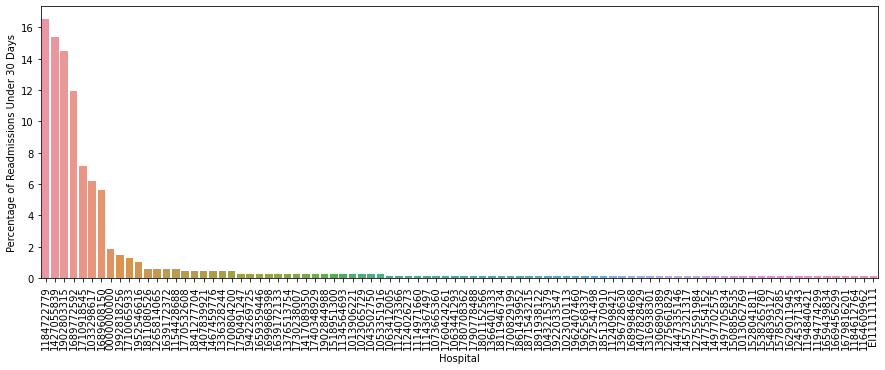

In [95]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(data=read_by_hospital, x='Hospital', y='Percentage of Readmissions Under 30 Days')
plt.xticks(rotation=90);

In [72]:
#count admissions per hospital
stay_per_hospital = hosp_stay.groupby('Facility Provider NPI')['Patient ID'].count().reset_index().sort_values('Patient ID',ascending=False)
stay_per_hospital = stay_per_hospital.rename({'Patient ID':'Count of Admissions','Facility Provider NPI':'Hospital'}, axis=1)
stay_per_hospital


,Hospital,Count of Admissions
185,1902803315,1204
46,1184722779,1196
91,1427055839,889
139,1689772592,679
12,1033298617,460
...,...,...
136,1679659585,1
135,1669456299,1
134,1659538858,1
75,1356307581,1


In [97]:
#Calculate % Readmissions Under 30 days by hospital by merging grouped admissions with grouped readmissions, calculating percent
rates_by_hosp = stay_per_hospital.merge(read_by_hospital,on='Hospital')
rates_by_hosp = rates_by_hosp.drop(columns='Percentage of Readmissions Under 30 Days')
rates_by_hosp['% Readmissions Under 30 days'] = round((rates_by_hosp['Count of Readmissions']/
                                                      rates_by_hosp['Count of Admissions'])*100,2)
rates_by_hosp.sort_values('% Readmissions Under 30 days',ascending=False)

,Hospital,Count of Admissions,Count of Readmissions,% Readmissions Under 30 days
89,1194840421,1,1,100.00
78,1548393127,1,1,100.00
67,1376513754,2,2,100.00
69,1013062769,1,1,100.00
70,1851370910,1,1,100.00
...,...,...,...,...
0,1902803315,1204,101,8.39
7,1710065933,109,9,8.26
11,1902844988,26,2,7.69
14,1306890389,16,1,6.25


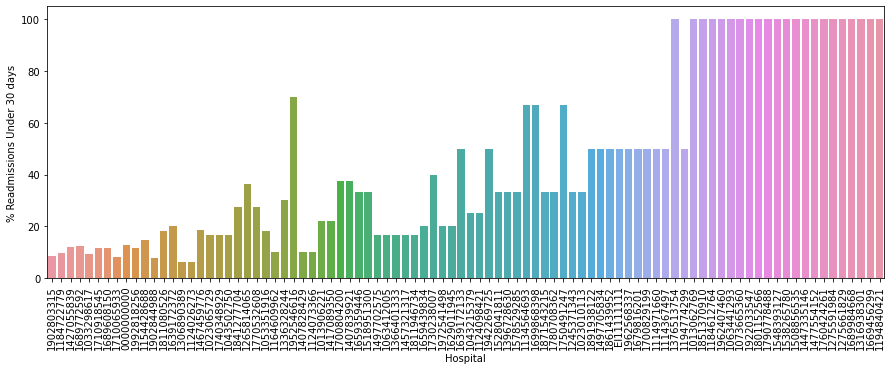

In [98]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(data=rates_by_hosp, x='Hospital', y='% Readmissions Under 30 days')
plt.xticks(rotation=90);

#### 3b. What are the rates of Under 30 by group PCP?

In [112]:
#calculate how many patients go to each group. calculate how many of those patients have had under-30 day readmissions
provider_groups = pc_visits.groupby('Provider Group NPI')['Patient ID'].count().reset_index()
provider_groups['Provider Group NPI'] = provider_groups['Provider Group NPI'].astype(str)
provider_groups = provider_groups.rename({'Patient ID':'Patient Count'},axis=1)
provider_groups

,Provider Group NPI,Patient Count
0,0.0,52
1,1003833179.0,2
2,1003864174.0,61
3,1003864182.0,1
4,1003896648.0,427
...,...,...
375,1982752515.0,1
376,1992027593.0,5
377,1992804462.0,1
378,1992897508.0,10


In [ ]:
#merge hospital admissions with pcp visits to match Patient ID to group PCP NPI
hosp_admish_w_group_pcp

#merge hospital readmissions with pcp visits to match Patient ID to group PCP NPI
hosp_readmish_w_group_pcp

### Bonus:
### 4. Which individual or PCP groups should we make an extra effort with to build a relationship? Which have the highest volume

### 5. What percent of our patients do not have a PCP assigned or haven't seen their PCP recently?

### 6. Are there certain patients we should focus on (e.g. frequent fliers)?

### 7. From this, what could a version 1 of an actionable dashboard or intervention list look like to support the Transition Care Managers?